<a href="https://colab.research.google.com/github/RegiRau/Vein_Segmentation/blob/main/Retrain_Vein_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Choose run_number and training number
import os
run_number = 'run_1'
training_number = 2
previous_checkpoint_path = '/content/gdrive/MyDrive/Vein_Segmentation_Models/' + run_number + '/Checkpoints_training1/cp.ckpt'
previous_checkpoint_dir = os.path.dirname(previous_checkpoint_path)

!mkdir '/content/gdrive/MyDrive/Vein_Segmentation_Models/run_1/Checkpoints_training2'
checkpoint_path = '/content/gdrive/MyDrive/Vein_Segmentation_Models/' + run_number + '/Checkpoints_training2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Vein_Segmentation_Models/run_1/Checkpoints_training2’: File exists


In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

In [ ]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='binary')
      IoU.append(jaccard)     
   return np.mean(IoU) 

In [ ]:
%%capture
!pip install wandb
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


In [ ]:
#importing models
from tensorflow.keras.optimizers import Adam
import tensorflow.python.keras as keras
import tensorflow as tf

# Initialize model like you usually do.
tf.keras.backend.clear_session()

IMG_CHANNELS = 1
SIZE_X = 1632
SIZE_Y = 1216
IMG_HEIGHT = SIZE_Y
IMG_WIDTH = SIZE_X
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = attentionunet(input_shape)

model.compile(optimizer = Adam(learning_rate = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
#model.compile(optimizer = Adam(config.learning_rate), loss= keras.losses.BinaryCrossentropy(), metrics= ['accuracy'])

#tensorflow.keras.utils.plot_model(model, "Attention-Unet.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1216, 1632,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1216, 1632,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1216, 1632,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

In [ ]:
import numpy as np
x_test = np.load('/content/gdrive/MyDrive/train_test_split/' + run_number + '/training1/x_test.npy')
y_test = np.load('/content/gdrive/MyDrive/train_test_split/' + run_number + '/training1/y_test.npy')

print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_test:  (135, 1216, 1632, 1)
Shape of y_test:  (135, 1216, 1632, 1)


In [ ]:
# train_loaded = tf.data.experimental.load('/content/gdrive/MyDrive/Datasets/run_1/train')
# test_loaded = tf.data.experimental.load('/content/gdrive/MyDrive/Datasets/run_1/test')
# val_loaded = tf.data.experimental.load('/content/gdrive/MyDrive/Datasets/run_1/val')

In [ ]:
# print(train_loaded)

In [ ]:
# tf.data.experimental.get_structure(
#     test_loaded
# )

In [ ]:
# Loads the weights
model.load_weights(previous_checkpoint_path)

In [ ]:
#model.load_weights('/content/gdrive/MyDrive/Vein_Segmentation_Models/' run_number + '/model_run' + run_number[4] + '_training1.hdf5')

In [ ]:
# Re-evaluate the model
test_scores = model.evaluate(x_test, y_test, batch_size = 3, verbose=2)
#test_scores = model.evaluate(test_loaded, batch_size = config.batch_size, verbose=2)

In [ ]:
from sklearn.metrics import jaccard_score,confusion_matrix
import cv2
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)

print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []
global_sensitivity = []
global_specificity = []
global_precision = []
global_F1_Score = []

for idx in range(x_test.shape[0]):
    test_img = x_test[idx, :, :, 0]
    testimg.append(test_img)
    test_img_norm = (test_img.astype('float32'))  # / 255.
    test_img_norm = np.expand_dims(np.array(test_img_norm), axis=-1)
    test_img_input = np.expand_dims(test_img_norm, 0)
    test_img_prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(
        np.uint8)  # predict on single patch
    prediction.append(test_img_prediction)

    groundtruth = y_test[idx, :, :, 0]
    groundtruth[groundtruth > 0.0] = 1.0
    groundtruth = np.array(groundtruth, dtype="uint8")
    ground_truth.append(groundtruth)

    y_true = groundtruth # 1 und 0
    y_pred = test_img_prediction  # 1 and 0
    labels = [0, 1]
    IoU = []  #Intersection over Union -> Schwellenwert, um zu ermitteln, ob ein vorhergesagtes Ergebnis ein
            #True Positive oder ein False Positive ist

    for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='binary')
      IoU.append(jaccard)
    IoU = np.mean(IoU) #jacard/IoU of single image
    global_IoU.append(IoU)

    cm=[]
    accuracy = []
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[1, 0])
    #cm[0,0]: true positives, c[1,1]: true negatives, c[1,0]: false positives, c[0,1]: false negatives
    accuracy = np.round((cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]), 4) #accuracy of single image
    sensitivity = np.round(cm[0,0]/(cm[0,0]+cm[0,1]), 4)
    specificity = np.round(cm[1,1]/(cm[1,1]+cm[1,0]), 4)
    precision = np.round(cm[0,0]/(cm[0,0]+cm[1,0]), 4)
    F1_Score = 2*precision*sensitivity/(precision+sensitivity)
    global_accuracy.append(accuracy)
    global_sensitivity.append(sensitivity)
    global_specificity.append(specificity)
    global_precision.append(precision)
    global_F1_Score.append(F1_Score)


avg_acc =  np.round(np.mean(global_accuracy), 4)
avg_sens = np.round(np.mean(global_sensitivity), 4)
avg_spec = np.round(np.mean(global_specificity), 4)
mean_IoU = np.round(np.mean(global_IoU), 4)
avg_F1_Score = np.round(np.mean(global_F1_Score), 4)

print('Average accuracy is',avg_acc)
print('Average sensitivity is', avg_sens)
print('Average specificity is', avg_spec)
print('mean IoU is',mean_IoU)
print('Average F1-Score is', avg_F1_Score)

Shape of x_test:  (135, 1216, 1632, 1)
Shape of y_test:  (135, 1216, 1632, 1)
Average accuracy is 0.9624
Average sensitivity is 0.6597
Average specificity is 0.9855
mean IoU is 0.7561
Average F1-Score is 0.7059


In [ ]:
!pip install wandb -qq
import pandas as pd
import numpy as np
import wandb
wandb.login()

wandb.init(project="Vein_Segmentation", name="run_1_training1_evaluation", entity="regirau")

In [ ]:
#create Table with Evaluation Scores

data = [[avg_acc, avg_sens, avg_spec, mean_IoU, avg_F1_Score]]
wandb.log({"Evaluation_Table_run1_training1": wandb.Table(data=data, columns=["Accuracy", "Sensitivity", "Specificity", "IoU", "F1-Score"])})

In [ ]:
#create Artifact with segmentation results

ds = wandb.Artifact("segmentation_results_test_data_run1_training1", "dataset")
test_table = wandb.Table(columns=["Image", "Groundtrugh", "Prediction"], data=[])
for i, g, p in zip(testimg, ground_truth, prediction):
  test_table.add_data(wandb.Image(i), wandb.Image(g), wandb.Image(p))
ds['test_data']=test_table
ds.save()

wandb.finish()

# Load Dataset

In [ ]:
!unzip /content/gdrive/MyDrive/Vein_Dataset_Resized.zip -d /content/

In [ ]:
import tensorflow as tf
dataset_images = tf.data
dataset_labels = tf.data
SIZE_X = 1632
SIZE_Y = 1216


dataset_images = tf.keras.utils.image_dataset_from_directory("Vein_Dataset_Resized/images", labels=None, label_mode=None, color_mode="grayscale", batch_size=1, image_size=(SIZE_Y, SIZE_X), shuffle=False, )
dataset_labels = tf.keras.utils.image_dataset_from_directory("Vein_Dataset_Resized/labels", labels=None, label_mode=None, color_mode="grayscale", batch_size=1, image_size=(SIZE_Y, SIZE_X), shuffle=False, )
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset_labels = dataset_labels.map(lambda x: (normalization_layer(x)))

Vein_Dataset = tf.data.Dataset.zip((dataset_images, dataset_labels))

In [ ]:
Vein_Dataset.shuffle(buffer_size = 1000)

Dataset_Size = 900

train_size = int(0.7 * Dataset_Size)
val_size = int(0.15 * Dataset_Size)
test_size = int(0.15 * Dataset_Size)

train_dataset = Vein_Dataset.take(train_size)
test_dataset = Vein_Dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
x_test = test_dataset.map(lambda a, b: a)
y_test = test_dataset.map(lambda a, b: b)

In [ ]:
print(train_dataset)
print(test_dataset)
print(val_dataset)

In [ ]:
!mkdir '/content/gdrive/MyDrive/train_test_split'
!mkdir '/content/gdrive/MyDrive/train_test_split/run_1'
!mkdir '/content/gdrive/MyDrive/train_test_split/run_1/training2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_test = []
y_test = []


for images, masks in test_dataset.take(test_size):
  sample_image, sample_mask = images[0, :, :, 0], masks[0, :, :, 0]
  x_test.append(sample_image)
  y_test.append(sample_mask)

x_test =  np.array(x_test)
y_test =  np.array(y_test)
x_test = np.expand_dims(x_test,axis=-1)
y_test = np.expand_dims(y_test,axis=-1)

np.save('/content/gdrive/MyDrive/train_test_split/' + run_number + '/training2/x_test.npy', x_test)
np.save('/content/gdrive/MyDrive/train_test_split/' + run_number + '/training2/y_test.npy', y_test)

# Create new Dataset to continue training

# Retrain the Model

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project="Vein_Segmentation", name="run_1_training2", entity="regirau",
                 config = {"learning_rate": 1e-3,
                           "epochs": 3,
                            "batch_size": 2,}
                )
config = wandb.config  # We'll use this to configure our experiment

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# We train with our beloved model.fit
# Notice WandbCallback is used as a regular callback
# We again use config here

# history = model.fit(x_train, y_train, 
#                     epochs = config.epochs,
#                     batch_size = config.batch_size,
#                     verbose=1,
#                     validation_data=(x_val, y_val),
#                     callbacks=[cp_callback, WandbCallback()])  #WandbCallback()])

# os.listdir(checkpoint_dir)


history = model.fit(train_dataset, 
                    epochs = config.epochs,
                    batch_size = config.batch_size,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[cp_callback, WandbCallback()])  #WandbCallback()])

os.listdir(checkpoint_dir)

In [ ]:
model.save('/content/gdrive/MyDrive/Vein_Segmentation_Models/' + run_number + '/model_run' + run_number[4] + '_training2.hdf5')

test_scores = model.evaluate(x_test, y_test, batch_size = config.batch_size, verbose=2)

3/3 - 2s - loss: -1.5709e-02 - accuracy: 0.8092 - IoU_coef: 0.0131 - 2s/epoch - 629ms/step


In [ ]:
from sklearn.metrics import jaccard_score,confusion_matrix
import cv2
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)

print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

testimg = []
ground_truth = []
prediction = []
global_IoU = []
global_accuracy = []
global_sensitivity = []
global_specificity = []
global_precision = []
global_F1_Score = []

for idx in range(x_test.shape[0]):
    test_img = x_test[idx, :, :, 0]
    testimg.append(test_img)
    test_img_norm = (test_img.astype('float32')) / 255.
    test_img_norm = np.expand_dims(np.array(test_img_norm), axis=-1)
    test_img_input = np.expand_dims(test_img_norm, 0)
    test_img_prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(
        np.uint8)  # predict on single patch
    prediction.append(test_img_prediction)

    groundtruth = y_test[idx, :, :, 0]
    groundtruth[groundtruth > 0.0] = 1.0
    groundtruth = np.array(groundtruth, dtype="uint8")
    ground_truth.append(groundtruth)

    y_true = groundtruth # 1 und 0
    y_pred = test_img_prediction  # 1 and 0
    labels = [0, 1]
    IoU = []  #Intersection over Union -> Schwellenwert, um zu ermitteln, ob ein vorhergesagtes Ergebnis ein
            #True Positive oder ein False Positive ist

    for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='binary')
      IoU.append(jaccard)
    IoU = np.mean(IoU) #jacard/IoU of single image
    global_IoU.append(IoU)

    cm=[]
    accuracy = []
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[1, 0])
    #cm[0,0]: true positives, c[1,1]: true negatives, c[1,0]: false positives, c[0,1]: false negatives
    accuracy = np.round((cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]), 4) #accuracy of single image
    sensitivity = np.round(cm[0,0]/(cm[0,0]+cm[0,1]), 4)
    specificity = np.round(cm[1,1]/(cm[1,1]+cm[1,0]), 4)
    precision = np.round(cm[0,0]/(cm[0,0]+cm[1,0]), 4)
    F1_Score = 2*precision*sensitivity/(precision+sensitivity)
    global_accuracy.append(accuracy)
    global_sensitivity.append(sensitivity)
    global_specificity.append(specificity)
    global_precision.append(precision)
    global_F1_Score.append(F1_Score)


avg_acc =  np.round(np.mean(global_accuracy), 4)
avg_sens = np.round(np.mean(global_sensitivity), 4)
avg_spec = np.round(np.mean(global_specificity), 4)
mean_IoU = np.round(np.mean(global_IoU), 4)
avg_F1_Score = np.round(np.mean(global_F1_Score), 4)

print('Average accuracy is',avg_acc)
print('Average sensitivity is', avg_sens)
print('Average specificity is', avg_spec)
print('mean IoU is',mean_IoU)
print('Average F1-Score is', avg_F1_Score)

In [ ]:
data = [[avg_acc, avg_sens, avg_spec, mean_IoU, avg_F1_Score]]
wandb.log({"Evaluation_Table_run1_training2": wandb.Table(data=data, columns=["Accuracy", "Sensitivity", "Specificity", "IoU", "F1-Score"])})

In [ ]:
#create Artifact with segmentation results

ds = wandb.Artifact("segmentation_results_test_data_run1_training2", "dataset")
test_table = wandb.Table(columns=["Image", "Groundtrugh", "Prediction"], data=[])
for i, g, p in zip(testimg, ground_truth, prediction):
  test_table.add_data(wandb.Image(i), wandb.Image(g), wandb.Image(p))
ds['test_data']=test_table
ds.save()

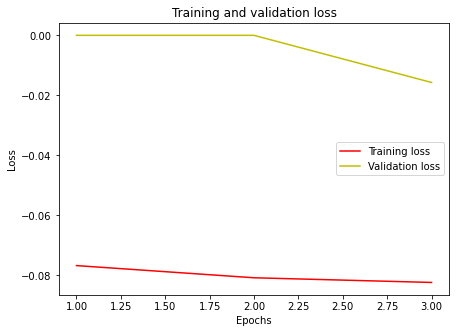

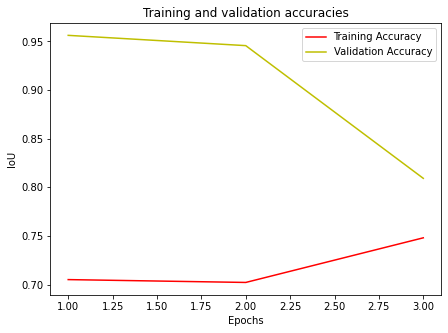

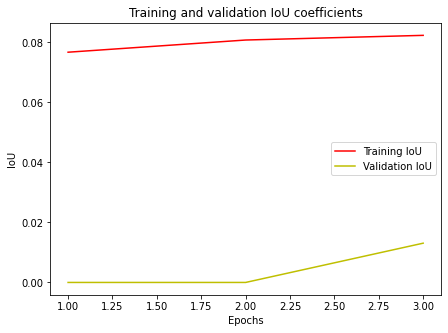

In [ ]:
import matplotlib.pyplot as plt

#training-validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training-validation accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(7,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#training-validation IoU curve
iou_coef = history.history['IoU_coef']
val_iou_coef = history.history['val_IoU_coef']
plt.figure(figsize=(7,5))
plt.plot(epochs, iou_coef, 'r', label='Training IoU')
plt.plot(epochs, val_iou_coef, 'y', label='Validation IoU')
plt.title('Training and validation IoU coefficients')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
wandb.finish()